# Import Required Libraries

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from itertools import product

# Load Data files

In [2]:
DATA_FILE_PATHS = '/workspace/rahnemacollege/Project/Git/demand-prediction/data'
start_date = pd.to_datetime('2023-04-01 00:00:00')
end_date = pd.to_datetime('2023-05-01 00:00:00')

In [3]:
def load_data(file_paths, start_date=None):
    df = pd.read_parquet(file_paths)
    df['date'] = df['tpep_pickup_datetime'].dt.date.astype(str)

    if start_date:
        df = df[df['date'] > start_date].reset_index(drop=True)

    return df


rides_df = load_data(DATA_FILE_PATHS, '2023-01-01')
print(rides_df.shape)
rides_df.head()

(12595923, 20)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,date
0,2,2023-01-02 00:00:37,2023-01-02 00:13:15,1.0,9.29,1.0,N,70,4,1,35.9,1.0,0.5,8.18,0.00,1.0,49.08,2.5,0.00,2023-01-02
1,2,2023-01-02 00:01:53,2023-01-02 00:34:16,1.0,20.40,2.0,N,132,238,1,70.0,0.0,0.5,15.86,6.55,1.0,95.16,0.0,1.25,2023-01-02
2,2,2023-01-02 00:04:59,2023-01-02 00:12:03,5.0,1.68,1.0,N,142,229,1,10.0,1.0,0.5,2.25,0.00,1.0,17.25,2.5,0.00,2023-01-02
3,2,2023-01-02 00:00:28,2023-01-02 00:08:45,1.0,1.74,1.0,N,164,224,1,10.7,1.0,0.5,0.00,0.00,1.0,15.70,2.5,0.00,2023-01-02
4,2,2023-01-02 00:00:08,2023-01-02 00:04:30,6.0,0.63,1.0,N,144,231,1,6.5,1.0,0.5,0.00,0.00,1.0,11.50,2.5,0.00,2023-01-02


In [4]:
def labeling(rides_df: pd.DataFrame):
    aggregated_df = rides_df.groupby(
        ['date', 'PULocationID']).size().reset_index(name='count')
    unique_dates = rides_df['date'].unique()
    unique_pu_location_ids = rides_df['PULocationID'].unique()
    all_combinations = list(product(unique_dates, unique_pu_location_ids))
    combinations_df = pd.DataFrame(all_combinations, columns=[
                                   'date', 'PULocationID'])
    label_df = aggregated_df.merge(combinations_df, how='right', on=[
                                   'date', 'PULocationID']).fillna(0)
    return label_df


labels_df = labeling(rides_df)
print(labels_df.shape)
labels_df.head()

(31964, 3)


,date,PULocationID,count
0,2023-01-02,70,503.0
1,2023-01-02,132,6419.0
2,2023-01-02,142,2028.0
3,2023-01-02,164,1462.0
4,2023-01-02,144,567.0


### Improved Data Bound Within Range: 2023-04-01 to 2023-04-30

For Testing Purpose

In [5]:
labels_df['date'] = pd.to_datetime(labels_df['date'])

In [6]:
filtered_rides_df = labels_df[(labels_df['date'] >= start_date) & (
    labels_df['date'] < end_date)]

In [7]:
# Sort the DataFrame based on the 'tpep_pickup_datetime' column in ascending order
filtered_rides_df = filtered_rides_df.sort_values(by='date')

In [8]:
filtered_rides_df = filtered_rides_df.reset_index(drop=True)

In [9]:
filtered_rides_df['pred_count'] = filtered_rides_df['count']

In [10]:
filtered_rides_df.head(10)

,date,PULocationID,count,pred_count
0,2023-04-01,70,373.0,373.0
1,2023-04-01,3,0.0,0.0
2,2023-04-01,147,3.0,3.0
3,2023-04-01,122,1.0,1.0
4,2023-04-01,86,2.0,2.0
5,2023-04-01,5,1.0,1.0
6,2023-04-01,49,25.0,25.0
7,2023-04-01,85,1.0,1.0
8,2023-04-01,255,158.0,158.0
9,2023-04-01,117,2.0,2.0


# Report by MAPE Metric

### Define MAPE Metric Function

In [11]:
# Define the MAPE calculation function
def calculate_mape(actual, predicted):
    if np.all(actual == 0):
        return 0.0
    return (abs((actual - predicted) / actual)).mean() * 100


# Calculate MAPE
mape = calculate_mape(
    filtered_rides_df['count'], filtered_rides_df['pred_count'])
print("MAPE: {:.2f}%".format(mape))

MAPE: 0.00%


### Calculate MAPE per LocationID

In [12]:
def calculate_mape_locationID(df, PULocationID):
    selected_df = df[df['PULocationID'] == PULocationID]
    actual = selected_df['count']
    predicted = selected_df['pred_count']
    mape = calculate_mape(actual, predicted)
    return mape

In [13]:
locationID_mape = 263
calculate_mape_locationID(filtered_rides_df, locationID_mape)
print("MAPE for LocationID {}: {:.2f}%".format(locationID_mape, mape))

MAPE for LocationID 263: 0.00%


### Calculate Average MAPE per all LocationIDs

In [14]:
PULocationIDs = filtered_rides_df['PULocationID'].unique()
PULocationIDs.sort()
for locationID in PULocationIDs:
    mape_all = []
    mape_all.append(calculate_mape_locationID(filtered_rides_df, locationID))
    AvgMAPE = sum(mape_all)/len(PULocationIDs)

print("Average MAPE per LocationIDs: {:.2f}%".format(mape))

Average MAPE per LocationIDs: 0.00%


## Visualization

Zones (Borough): **EWR, Queens, Bronx, Manhattan, Staten Island, Brooklyn**

Date Range: **2023-04-01_2023-04-30**

In [15]:
# This Function shows demand on map based on selected date on month
# Becuase of to many locationIDs, we limited our visualization to each zone(Borough)
def visualize_mape_zone_date(zone, date, df):
    shape = gpd.read_file(
        '/workspace/rahnemacollege/Project/Git/demand-prediction/map_data/taxi_zones/taxi_zones.shp')
    counts_PU = df.rename(columns={'PULocationID': 'LocationID'})
    counts_PU = counts_PU[counts_PU['date'] == date]
    merged_gdf = shape.merge(counts_PU, on='LocationID', how='left')
    merged_gdf = merged_gdf.dropna()
    merged_gdf['MAPE'] = np.where(merged_gdf['count'] != 0, (abs(
        (merged_gdf['count'] - merged_gdf['pred_count']) / merged_gdf['count'])) * 100, 0)
    merged_gdf_selected = merged_gdf[merged_gdf['borough'] == zone]

    # Create a single plot
    fig, ax = plt.subplots(figsize=(10, 7.5))

    # Plot the map with 'count' column
    # Reverse the colormap by setting vmin and vmax to reverse the values
    merged_gdf_selected.plot(column='MAPE', cmap='Oranges_r', legend=True, ax=ax,
                             vmin=merged_gdf_selected['MAPE'].max(), vmax=merged_gdf_selected['MAPE'].min())
    ax.set_title('Prediction based on MAPE')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Annotate 'MAPE' values on the map
    for idx, row in merged_gdf_selected.iterrows():
        location_id = row['MAPE']
        x, y = row.geometry.centroid.x, row.geometry.centroid.y
        ax.text(x, y, str(location_id), fontsize=8,
                ha='center', va='center', color='black')

    plt.show()

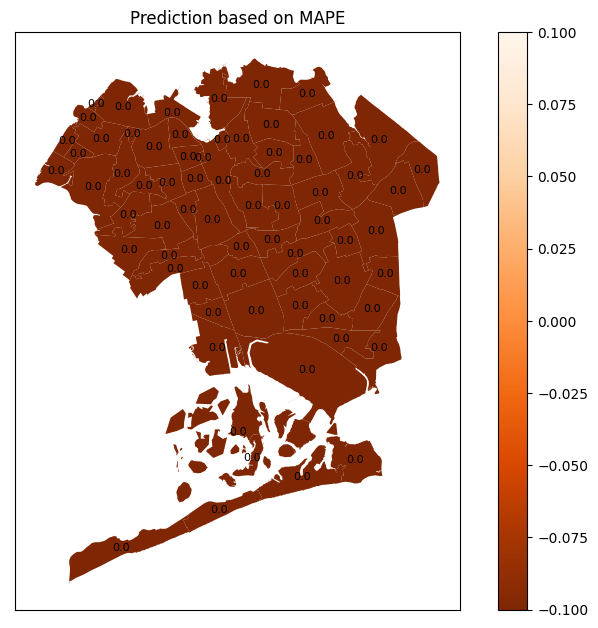

In [16]:
visualize_mape_zone_date('Queens', '2023-04-01', filtered_rides_df)